# Tutorial 09

## template fitting mock data test (B mode, parametric CMB)

The `simple likelihood` is designed for pipeline's sanity check:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.ps_estimator import pstimator
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cambmodel
import seaborn as sns
from dynesty import utils as dyfunc
from getdist import plots, MCSamples
import warnings
warnings.filterwarnings('ignore')

TARGET = 'B'
NSIDE = 128
NSAMP = 30
APOSCALE = 6.
PSBIN = 60
LMIN = 50
LMAX = 200
FREQS = [95.,150.]
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
mapcmb = np.empty((NSAMP+1,3,map30f.shape[1]),dtype=np.float32)
for i in range(NSAMP+1):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
#vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
#vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap95 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap150.shape[1]))*np.sqrt(vmap150)
#nmap30 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap30.shape[1]))*np.sqrt(vmap30)
#nmap353 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap353.shape[1]))*np.sqrt(vmap353)

map95 = hp.smoothing(mapcmb[0]+map95f,fwhm=fwhm[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb[0]+map150f,fwhm=fwhm[2],verbose=0)+nmap150[0]
#map30 = hp.smoothing(mapcmb+map30f,fwhm=fwhm[0],verbose=0)+nmap30[0]
#map353 = hp.smoothing(mapcmb+map353f,fwhm=fwhm[3],verbose=0)+nmap353[0]

fullmap = dict()
fullmap[95] = map95
fullmap[150] = map150

fullnoise = dict()
fullnoise[95] = nmap95[1:]
fullnoise[150] = nmap150[1:]

fullfiducial = dict()
fullfiducial[95] = mapcmb[1:]
fullfiducial[150] = mapcmb[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f
tmpmap[353] = map353f

tmpbeam = dict()
tmpbeam[30] = fwhm[0]
tmpbeam[353] = fwhm[3]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### 1st run with sync model

- mock data frequencies: 95, 150
- template frequency: 30
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw

fg truths:  {'beta_s': -3.0}
cmb truths:  {'r': 0.05, 'Lb': 1.0}
CPU times: user 32min 57s, sys: 3.95 s, total: 33min 1s
Wall time: 4min 16s


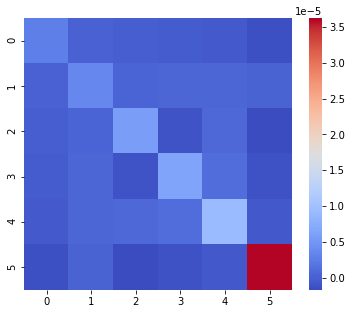

In [2]:
%%time

tmpmap = dict()
tmpmap[30] = map30f

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=None,targets=TARGET)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

s = syncmodel(freqlist=FREQS,targets=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=tmpmap,template_fwhms=None)
s.reset({'beta_s':-3.})

b = cambmodel(freqlist=FREQS,targets=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
b.reset({'r': 0.05})
b.reset({'Lb':1.})

print ('fg truths: ',s.params)
print ('cmb truths: ',b.params)

mock_bp = s.bandpower()+b.bandpower()

iter: 3994 | +1000 | bound: 1 | nc: 1 | ncall: 37042 | eff(%): 13.482 | loglstar:   -inf < -0.001 <    inf | logz: -3.746 +/-  0.066 | dlogz:  0.001 >  1.009                                         

Removed no burn in


iter: 4023 | +1000 | bound: 1 | nc: 1 | ncall: 37369 | eff(%): 13.442 | loglstar:   -inf < -0.001 <    inf | logz: -3.779 +/-  0.069 | dlogz:  0.001 >  1.009                                         

Removed no burn in


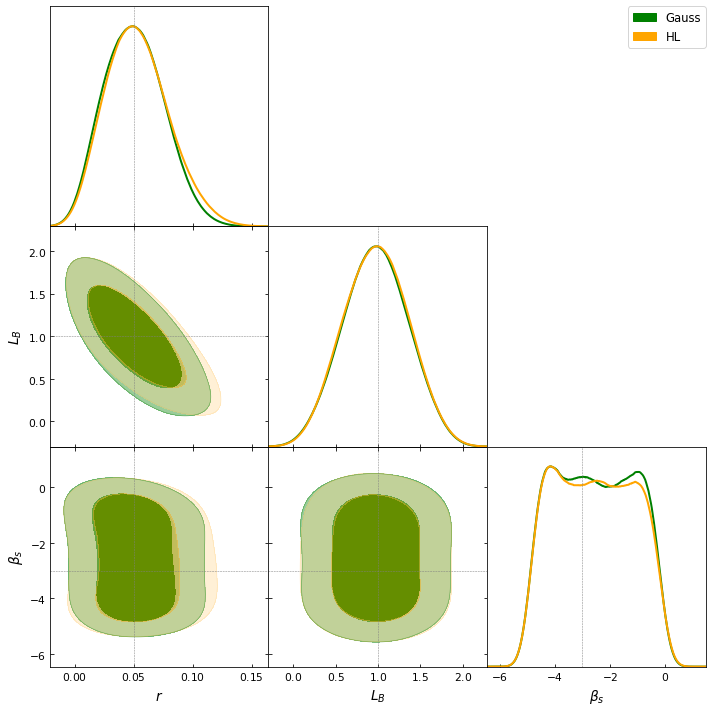

In [3]:
names = [r'$r$',r'$L_B$',r'$\beta_s$']
truths = [0.05,1.,-3.]
KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = s
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
pipeline.likelihood='gauss'
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

pipeline.likelihood='hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### 2nd run with dust model

- mock data frequencies: 95, 150
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

fg truths:  {'beta_d': 1.5}
cmb truths:  {'r': 0.05, 'Lb': 1.0}
CPU times: user 39min 52s, sys: 1.08 s, total: 39min 53s
Wall time: 5min 8s


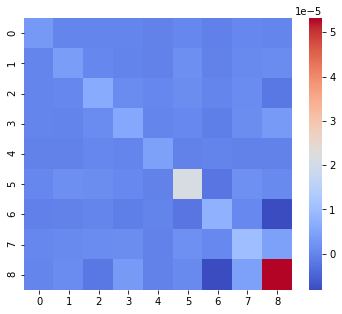

In [4]:
%%time

tmpmap = dict()
tmpmap[353] = map353f

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=None,targets=TARGET)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

d = dustmodel(freqlist=FREQS,targets=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=tmpmap,template_fwhms=None)
d.reset({'beta_d':1.5})

b = cambmodel(freqlist=FREQS,targets=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
b.reset({'r':0.05})
    
print ('fg truths: ',d.params)
print ('cmb truths: ',b.params)

mock_bp = d.bandpower()+b.bandpower()

iter: 8057 | +1000 | bound: 7 | nc: 1 | ncall: 46655 | eff(%): 19.413 | loglstar:   -inf < -0.015 <    inf | logz: -7.944 +/-  0.127 | dlogz:  0.001 >  1.009                                         

Removed no burn in


iter: 6747 | +1000 | bound: 6 | nc: 1 | ncall: 44311 | eff(%): 17.483 | loglstar:   -inf < -0.007 <    inf | logz: -6.616 +/-  0.114 | dlogz:  0.001 >  1.009                                         

Removed no burn in


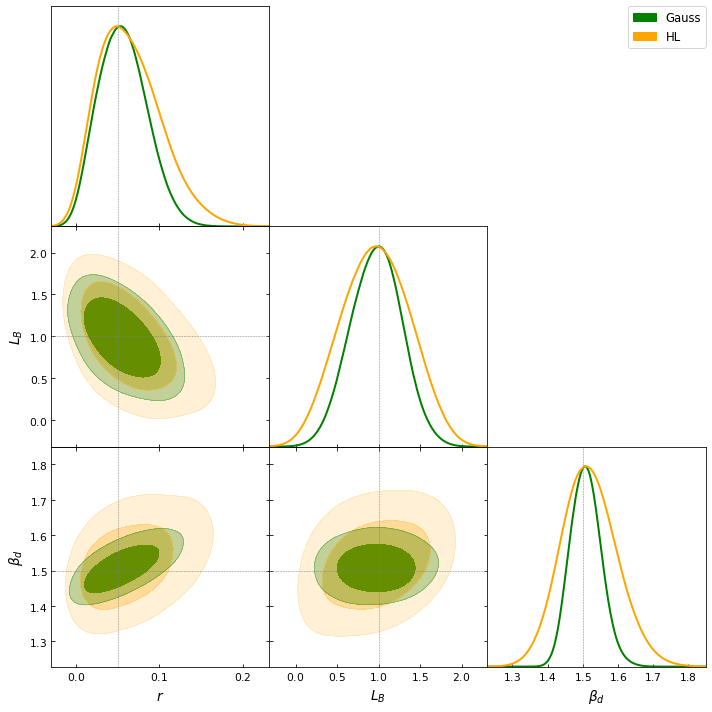

In [5]:
names = [r'$r$',r'$L_B$',r'$\beta_d$']
truths = [0.05,1.,1.5]
KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = d
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
pipeline.likelihood='gauss'
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

pipeline.likelihood='hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### 3rd run with sync+dust model

- mock data frequencies: 95, 150
- template frequency: 30, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

fg truths:  {'beta_s': -3.0, 'beta_d': 1.5, 'rho': 0.1}
cmb truths:  {'r': 0.05, 'Lb': 1.0}
CPU times: user 46min 11s, sys: 604 ms, total: 46min 12s
Wall time: 5min 47s


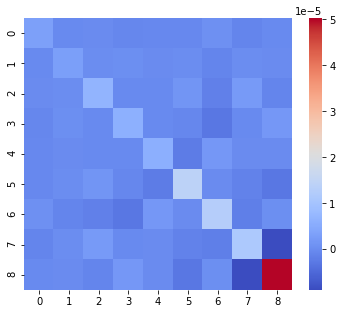

In [6]:
%%time

tmpmap = dict()
tmpmap[30] = map30f
tmpmap[353] = map353f

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=None,targets=TARGET)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

c = syncdustmodel(freqlist=FREQS,targets=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
                  templates=tmpmap,template_fwhms=None)
c.reset({'beta_s':-3.})
c.reset({'beta_d':1.5})
c.reset({'rho':0.1})

b = cambmodel(freqlist=FREQS,targets=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
b.reset({'r':0.05})
    
print ('fg truths: ',c.params)
print ('cmb truths: ',b.params)

mock_bp = c.bandpower()+b.bandpower()

iter: 8260 | +1000 | bound: 12 | nc: 1 | ncall: 52729 | eff(%): 17.561 | loglstar:   -inf < -0.009 <    inf | logz: -8.161 +/-  0.131 | dlogz:  0.001 >  1.009                                        

Removed no burn in


iter: 7097 | +1000 | bound: 7 | nc: 1 | ncall: 47405 | eff(%): 17.080 | loglstar:   -inf < -0.008 <    inf | logz: -6.996 +/-  0.121 | dlogz:  0.001 >  1.009                                         

Removed no burn in


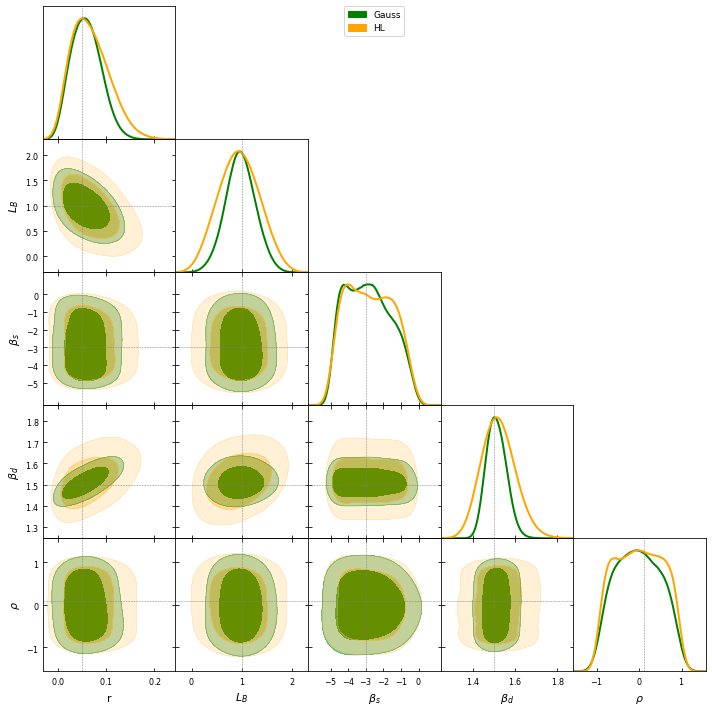

In [7]:
names = [r'r',r'$L_B$',r'$\beta_s$',r'$\beta_d$',r'$\rho$']
truths = [0.05,1.,-3.,1.5,0.1]
KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = c
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
pipeline.likelihood='gauss'
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

pipeline.likelihood='hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)